In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
# preprocessing
import re
import string
import nltk
from nltk import  pos_tag
from nltk.corpus import stopwords
import nltk.stem as stemmer

from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec


from collections import Counter
# Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report



In [2]:
#read data
dataset= pd.read_csv('PolitiFact_stp_fS_fe_stm.csv')
dataset

,statement,statement_originator,polarity,factchecker,statement_source,review_len,word_count,label
0,us embassy celebrates america’s independence j...,0,0.000000,0,0,75,9,1
1,united states america twentysixth school perfo...,1,0.000000,1,1,58,7,1
2,says obama administration plans ban weapons us...,2,0.000000,2,2,78,10,0
3,since texas clean air program achieved percent...,3,0.366667,3,3,93,13,1
4,led fight require coast guard buy engines us f...,4,-0.125000,4,4,62,10,0
...,...,...,...,...,...,...,...,...
9995,fda approval means nothing realize fda also ap...,5,0.000000,358,0,68,10,0
9996,epa officials commended koch industries ‘commi...,2785,0.000000,111,3,102,13,0
9997,dave aronberg first demand bp create billiondo...,2786,0.250000,6,8,71,10,1
9998,heidi cruz ted’s wife managing director goldma...,5,0.000000,12,0,77,11,0


In [3]:
#rename the title column to news
dataset.rename(columns= {'statement': 'news'}, inplace= True)

In [4]:
df= dataset[['news']]
label= dataset[['label']]
other_features= dataset.drop(['news', 'label'], axis= 1)
other_features.head(3)

,statement_originator,polarity,factchecker,statement_source,review_len,word_count
0,0,0.0,0,0,75,9
1,1,0.0,1,1,58,7
2,2,0.0,2,2,78,10


In [5]:
# cleanning dataset

In [6]:
def remove_URL(text):
  url= re.compile(r'https?://\S+|www\.|S+')
  return url.sub(r"", text)

In [7]:
def remove_punctuation(text):
  trnsltr= str.maketrans("","", string.punctuation)
  return text.translate(trnsltr)

In [8]:
df['news']= df['news'].map(remove_punctuation)
df['news']= df['news'].map(remove_URL)

<ipython-input-8-ee23033ab2f2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df['news'].map(remove_punctuation)
<ipython-input-8-ee23033ab2f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df['news'].map(remove_URL)


In [9]:
#remove stop words

In [10]:
nltk.download('stopwords')
stop= set(stopwords.words("english"))
def remove_stopwords(text):
  result= [word.lower() for word in text.split() if word.lower() not in stop]
  return ' '.join(result)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
df['news']= df.news.map(remove_stopwords)

<ipython-input-11-b1b16693267d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news']= df.news.map(remove_stopwords)


In [12]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [13]:
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()

pos= pos_tag(df['news'])
df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]



<ipython-input-13-75a18c877c3d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['news'] = [stemmer.stem(tagged_word[0]) for tagged_word in pos]


In [14]:
df

,news
0,us embassy celebrates america’s independence j...
1,united states america twentysixth school perfo...
2,says obama administration plans ban weapons us...
3,since texas clean air program achieved percent...
4,led fight require coast guard buy engines us f...
...,...
9995,fda approval means nothing realize fda also ap...
9996,epa officials commended koch industries ‘commi...
9997,dave aronberg first demand bp create billiondo...
9998,heidi cruz ted’s wife managing director goldma...


In [15]:
# counting unique words of news column
def count_words(text_col):
  counter= Counter()
  for text in text_col:
    for word in text.split():
      counter[word] += 1
  return counter


In [16]:
counter= count_words(df['news'])

In [17]:
# number of unique words
len(counter)

14431

In [18]:
unique_words_num= len(counter)

In [19]:
embedding_dim= 100

In [20]:
X= [x.split() for x in df['news'].tolist()]

In [21]:
print(most_common:= counter.most_common(5))

[('says', 2507), ('percent', 673), ('year', 613), ('tax', 590), ('people', 587)]


In [22]:
# vectorize a text into a sequence of integers by tokenizing
# converting text into a sequence of integers
def tokenize(text):
  tokenizer= Tokenizer(num_words= unique_words_num)
  tokenizer.fit_on_texts(text)
  return tokenizer

In [23]:
tokenizer= tokenize(X)


In [24]:
print(word_index:= tokenizer.word_index)

{'says': 1, 'percent': 2, 'year': 3, 'tax': 4, 'people': 5, 'state': 6, 'president': 7, 'obama': 8, 'us': 9, 'million': 10, 'health': 11, 'new': 12, 'would': 13, 'said': 14, 'one': 15, 'trump': 16, 'states': 17, 'billion': 18, 'years': 19, 'care': 20, 'bill': 21, 'every': 22, 'texas': 23, 'voted': 24, 'federal': 25, 'barack': 26, 'united': 27, 'last': 28, 'jobs': 29, 'donald': 30, 'school': 31, 'since': 32, 'budget': 33, 'first': 34, 'law': 35, 'pay': 36, 'biden': 37, 'government': 38, 'wisconsin': 39, 'money': 40, 'taxes': 41, 'shows': 42, 'job': 43, 'even': 44, 'get': 45, 'plan': 46, 'clinton': 47, 'florida': 48, 'american': 49, 'joe': 50, 'rate': 51, 'two': 52, 'republican': 53, 'americans': 54, 'house': 55, 'time': 56, 'country': 57, 'cut': 58, 'public': 59, 'st': 60, 'national': 61, 'america': 62, 'never': 63, 'illegal': 64, 'right': 65, 'going': 66, 'senate': 67, 'hillary': 68, 'world': 69, 'women': 70, 'go': 71, '…': 72, 'like': 73, 'gov': 74, 'city': 75, 'day': 76, 'congress': 

In [25]:
tokenizer.word_counts

OrderedDict([('us', 491),
             ('embassy', 8),
             ('celebrates', 2),
             ('america’s', 18),
             ('independence', 7),
             ('june', 11),
             ('order', 40),
             ('accommodate', 2),
             ('muslim', 35),
             ('united', 262),
             ('states', 356),
             ('america', 163),
             ('twentysixth', 1),
             ('school', 250),
             ('performance', 3),
             ('world', 154),
             ('says', 2507),
             ('obama', 519),
             ('administration', 129),
             ('plans', 34),
             ('ban', 68),
             ('weapons', 31),
             ('citizens', 45),
             ('international', 21),
             ('treati', 1),
             ('since', 248),
             ('texas', 290),
             ('clean', 21),
             ('air', 36),
             ('program', 123),
             ('achieved', 3),
             ('percent', 673),
             ('reduction', 18),
   

In [26]:
text_sentences= df['news'].to_numpy()
text_sequences= tokenizer.texts_to_sequences(X)


In [27]:
print(text_sentences[100])
print(text_sequences[100])

year obama administration released criminal illegal aliens released murderers – people homicide convictions illeg
[3, 8, 99, 573, 434, 64, 736, 573, 3543, 460, 5, 3544, 3545, 857]


In [28]:
#reversing tokenization
# test_sequences

In [29]:
# min and max lengh of train sequences
train_min_lenght= len(min(text_sequences, key= len))
train_max_lenght= len(max(text_sequences, key= len))
train_min_lenght , train_max_lenght


(1, 44)

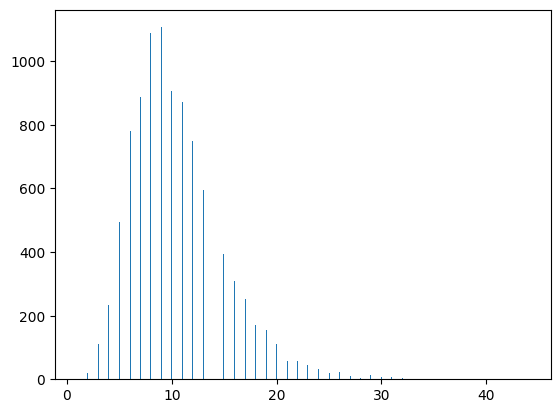

In [30]:
# plotting len of each sentence
plt.hist([len(x) for x in X], bins=500);

In [31]:
sentence_len= np.array([len(x) for x in X])
print(f'There are {len(sentence_len[sentence_len > 25])} sentences which have more than 25 words.')
max_len= 25

There are 76 sentences which have more than 25 words.


In [32]:
# padding
def padding_sequences(seq, max_len):
  return pad_sequences(seq, maxlen= max_len, padding= "post", truncating="post")

In [33]:
text_padded= padding_sequences(text_sequences, max_len)

In [34]:
print(text_sentences[100])
print(text_sequences[100])
print(text_padded[100])

year obama administration released criminal illegal aliens released murderers – people homicide convictions illeg
[3, 8, 99, 573, 434, 64, 736, 573, 3543, 460, 5, 3544, 3545, 857]
[   3    8   99  573  434   64  736  573 3543  460    5 3544 3545  857
    0    0    0    0    0    0    0    0    0    0    0]


In [35]:
# checking tokenization by reversing from sequences to sentences
# filp word_index dictionay index and value
reversed_index= dict([(idx, word) for (word, idx) in word_index.items()])

In [36]:
def decode(seq):
  result= " ".join([reversed_index.get(idx, "?") for idx in seq])
  return result

In [37]:
decoded_news= decode(text_sequences[100])
print(text_sequences[100])
print(text_sentences[100])
print(decoded_news)

[3, 8, 99, 573, 434, 64, 736, 573, 3543, 460, 5, 3544, 3545, 857]
year obama administration released criminal illegal aliens released murderers – people homicide convictions illeg
year obama administration released criminal illegal aliens released murderers – people homicide convictions illeg


In [38]:
#concatinating other features to tokenized data

In [39]:
##### concatnate if other features exist
full_df_padded= np.hstack([text_padded, other_features])
max_len+= len(other_features.columns)


In [40]:
# vocab_size
vocab_size= len(tokenizer.word_index) +1 # because word_index starts from zero

In [41]:
X_train, X_test, y_train, y_test= train_test_split(full_df_padded, label, test_size= 0.2, random_state= 10)

In [67]:

# create LSTM model
model= keras.models.Sequential()
model.add(layers.Embedding(unique_words_num, embedding_dim, input_length=max_len))
model.add(layers.LSTM(140, dropout= 0.1, kernel_regularizer=l2(0.01))) #
model.add(layers.Dense(1,  activation='sigmoid'))
loss= keras.losses.BinaryCrossentropy(from_logits= False)
optim= keras.optimizers.Adam(learning_rate=0.005)
metrics= ["accuracy"]#,  Precision(), Recall()]
model.compile(loss= loss, optimizer= optim, metrics= metrics)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 31, 100)           1443100   
                                                                 
 lstm_5 (LSTM)               (None, 140)               134960    
                                                                 
 dense_6 (Dense)             (None, 1)                 141       
                                                                 
Total params: 1,578,201
Trainable params: 1,578,201
Non-trainable params: 0
_________________________________________________________________


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)


Epoch 1/50
250/250 - 18s - loss: 0.7123 - accuracy: 0.5959 - val_loss: 0.6380 - val_accuracy: 0.6365 - 18s/epoch - 72ms/step
Epoch 2/50
250/250 - 5s - loss: 0.6006 - accuracy: 0.6967 - val_loss: 0.6444 - val_accuracy: 0.6460 - 5s/epoch - 20ms/step
Epoch 3/50
250/250 - 2s - loss: 0.5465 - accuracy: 0.7509 - val_loss: 0.6668 - val_accuracy: 0.6450 - 2s/epoch - 8ms/step
Epoch 4/50
250/250 - 2s - loss: 0.5108 - accuracy: 0.7772 - val_loss: 0.7381 - val_accuracy: 0.6530 - 2s/epoch - 9ms/step
Epoch 5/50
250/250 - 2s - loss: 0.4830 - accuracy: 0.7943 - val_loss: 0.7395 - val_accuracy: 0.6590 - 2s/epoch - 7ms/step
Epoch 6/50
250/250 - 2s - loss: 0.4646 - accuracy: 0.7986 - val_loss: 0.6989 - val_accuracy: 0.6605 - 2s/epoch - 9ms/step


In [69]:
y_pred= (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

63/63 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.72      0.65      0.68      1121
           1       0.60      0.68      0.64       879

    accuracy                           0.66      2000
   macro avg       0.66      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000



In [45]:
# Bidirectional LSTM
bi_model =  keras.models.Sequential()
bi_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  input_length= max_len , trainable=False))
bi_model.add(layers.Bidirectional(layers.LSTM(140, dropout=0.3,  kernel_regularizer=l2(0.01))))  # Use Bidirectional LSTM layer
bi_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
metrics = ["accuracy" ]#, Precision(), Recall()]

bi_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
bi_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)


Epoch 1/50
250/250 - 7s - loss: 1.4491 - accuracy: 0.5577 - val_loss: 0.7037 - val_accuracy: 0.5605 - 7s/epoch - 26ms/step
Epoch 2/50
250/250 - 2s - loss: 0.6889 - accuracy: 0.5570 - val_loss: 0.6854 - val_accuracy: 0.5605 - 2s/epoch - 9ms/step
Epoch 3/50
250/250 - 2s - loss: 0.6826 - accuracy: 0.5642 - val_loss: 0.6772 - val_accuracy: 0.5805 - 2s/epoch - 7ms/step
Epoch 4/50
250/250 - 2s - loss: 0.6719 - accuracy: 0.5819 - val_loss: 0.6498 - val_accuracy: 0.5870 - 2s/epoch - 7ms/step
Epoch 5/50
250/250 - 2s - loss: 0.6607 - accuracy: 0.5982 - val_loss: 0.6406 - val_accuracy: 0.6100 - 2s/epoch - 7ms/step
Epoch 6/50
250/250 - 2s - loss: 0.6476 - accuracy: 0.6127 - val_loss: 0.6651 - val_accuracy: 0.6275 - 2s/epoch - 7ms/step
Epoch 7/50
250/250 - 2s - loss: 0.6477 - accuracy: 0.6102 - val_loss: 0.6292 - val_accuracy: 0.6310 - 2s/epoch - 7ms/step
Epoch 8/50
250/250 - 2s - loss: 0.6431 - accuracy: 0.6196 - val_loss: 0.6492 - val_accuracy: 0.6400 - 2s/epoch - 8ms/step
Epoch 9/50
250/250 - 2s

In [47]:
y_pred= (bi_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

63/63 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.75      0.56      0.64      1121
           1       0.57      0.76      0.65       879

    accuracy                           0.65      2000
   macro avg       0.66      0.66      0.65      2000
weighted avg       0.67      0.65      0.65      2000



In [48]:
S_model =  keras.models.Sequential()
S_model.add(layers.Embedding(vocab_size, output_dim= embedding_dim,  input_length= max_len , trainable=False))
S_model.add(layers.SimpleRNN(140, dropout=0.1,  kernel_regularizer=l2(0.01)))
S_model.add(layers.Dense(1, activation='sigmoid'))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optim = tf.keras.optimizers.Adam(learning_rate=0.0005)
metrics = ["accuracy"] #, Precision(), Recall()]

S_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [49]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
S_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=2)



Epoch 1/50
250/250 - 7s - loss: 1.1947 - accuracy: 0.5821 - val_loss: 0.8469 - val_accuracy: 0.5875 - 7s/epoch - 28ms/step
Epoch 2/50
250/250 - 6s - loss: 0.7461 - accuracy: 0.6204 - val_loss: 0.6948 - val_accuracy: 0.6290 - 6s/epoch - 25ms/step
Epoch 3/50
250/250 - 5s - loss: 0.6691 - accuracy: 0.6348 - val_loss: 0.6561 - val_accuracy: 0.6345 - 5s/epoch - 19ms/step
Epoch 4/50
250/250 - 5s - loss: 0.6414 - accuracy: 0.6471 - val_loss: 0.6447 - val_accuracy: 0.6465 - 5s/epoch - 20ms/step
Epoch 5/50
250/250 - 5s - loss: 0.6304 - accuracy: 0.6518 - val_loss: 0.6246 - val_accuracy: 0.6390 - 5s/epoch - 22ms/step
Epoch 6/50
250/250 - 5s - loss: 0.6245 - accuracy: 0.6549 - val_loss: 0.6364 - val_accuracy: 0.6470 - 5s/epoch - 19ms/step
Epoch 7/50
250/250 - 6s - loss: 0.6242 - accuracy: 0.6596 - val_loss: 0.6414 - val_accuracy: 0.6355 - 6s/epoch - 23ms/step
Epoch 8/50
250/250 - 5s - loss: 0.6221 - accuracy: 0.6621 - val_loss: 0.6251 - val_accuracy: 0.6395 - 5s/epoch - 20ms/step
Epoch 9/50
250/2

In [50]:
y_pred= (S_model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred))

63/63 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1121
           1       0.60      0.61      0.60       879

    accuracy                           0.65      2000
   macro avg       0.64      0.64      0.64      2000
weighted avg       0.65      0.65      0.65      2000

